In [216]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import seaborn as sns
import pytensor.tensor as pt
import pymc as pm
import arviz as az
import pytensor

# Enable seaborn style for better aesthetics
sns.set_theme(style="whitegrid")

In [217]:
df = pd.read_csv("MMM_test_data.csv")
df["start_of_week"] = pd.to_datetime(df["start_of_week"], format="%d-%m-%y")
df.set_index("start_of_week", inplace=True)

### Data exploration
Following Bayes ideology, we will first get an idea of the data at hand (our prior) and then let a model fit to the data (likelihood). Our final findings (posterior) would then be a cross between our belief and likelihood and should lie somewhere in between the two. 

$posterior =  likelihood * prior$

The following cells will do some EDA so that we can form some prior of our data.

             revenue  spend_channel_1  spend_channel_2  spend_channel_3  \
count     104.000000       104.000000       104.000000       104.000000   
mean   136490.190673      1245.604808       343.640962     19507.177981   
std     50810.253012      1388.384632       332.988218      8714.759886   
min     63207.090000         0.000000         4.370000      5938.130000   
25%    101675.685000       334.275000       120.470000     13879.000000   
50%    128790.460000       856.870000       202.020000     17929.450000   
75%    157707.280000      1658.032500       553.075000     22252.262500   
max    418186.380000      8513.830000      1605.850000     49689.380000   

       spend_channel_4  spend_channel_5  spend_channel_6  spend_channel_7  
count       104.000000       104.000000       104.000000       104.000000  
mean       6915.136731      8575.611442      5063.699038     27701.367404  
std        3123.172035      6956.787524      6689.472660     12176.293684  
min        3602.2000

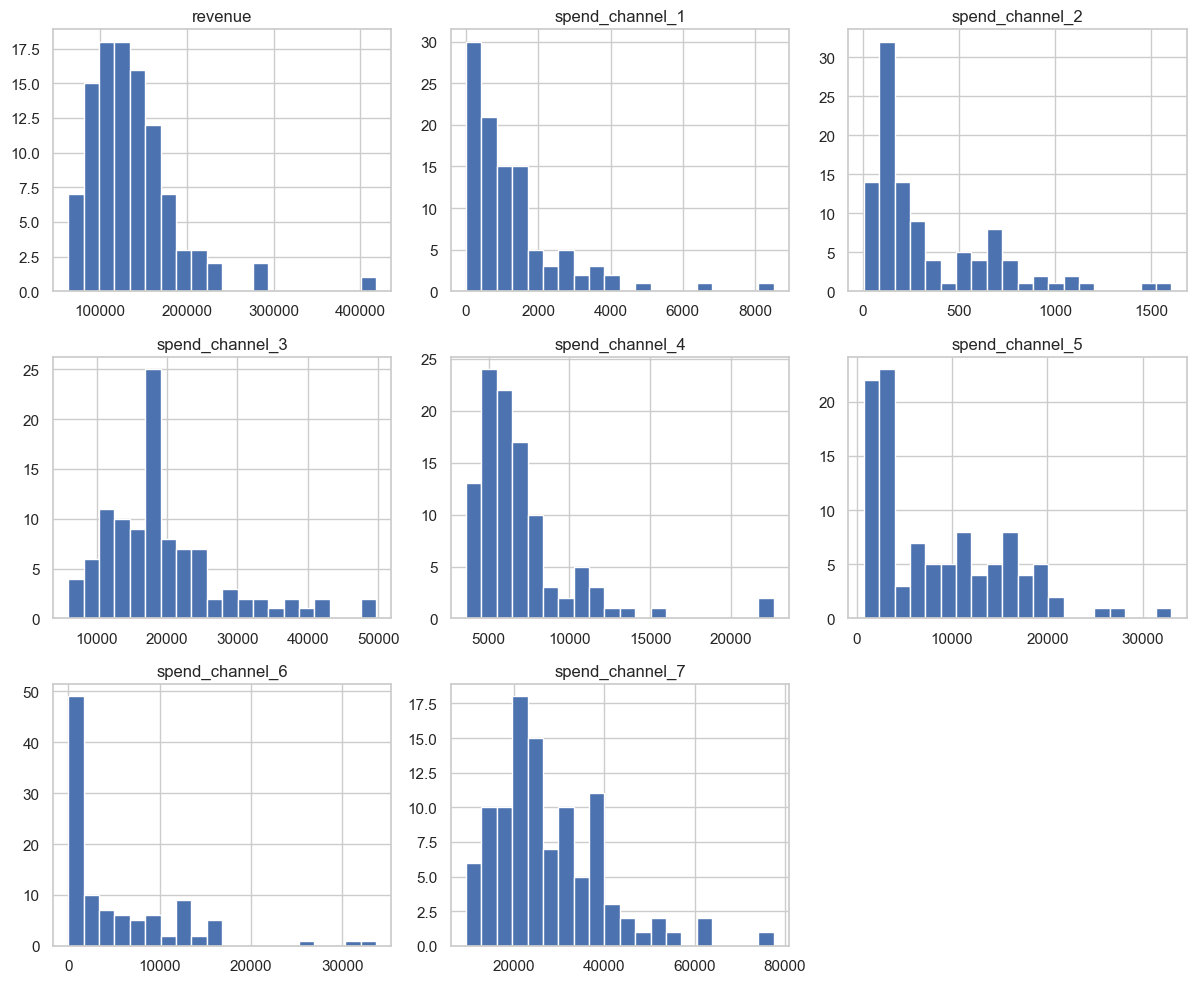

,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
start_of_week,,,,,,,,
2020-08-30,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79
2020-09-06,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45
2020-09-13,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05
2020-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73
2020-09-27,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48


In [218]:
# To see some basic stats of the dataset
print(df.describe())
# To plot all data -revenues, spend_channels in histograms
df.hist(figsize=(12, 10), bins=20)
plt.tight_layout()
plt.show()
# First few rows
df.head()

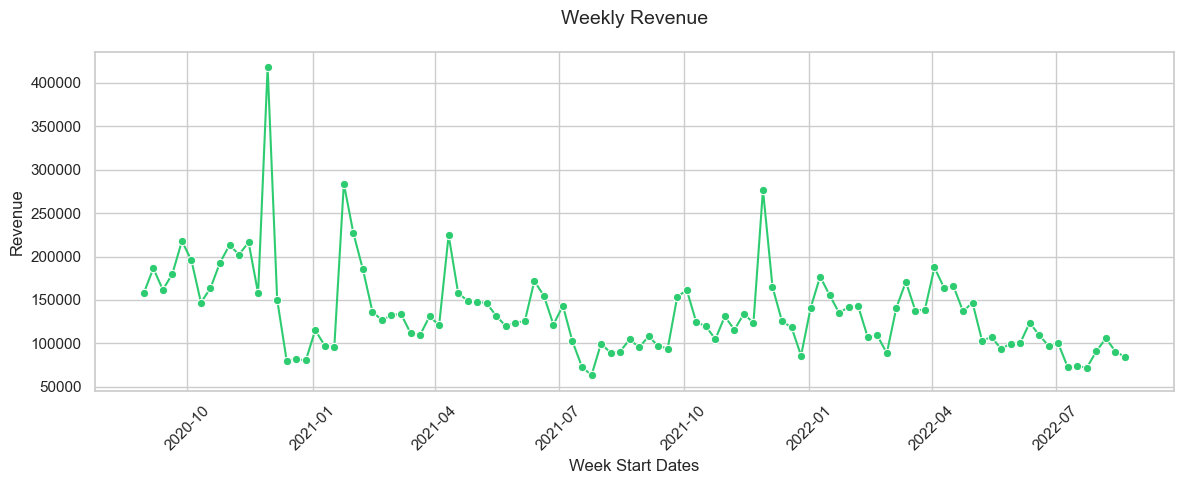

In [219]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x=df.index, y="revenue", marker="o", color="#2ecc71")
plt.title("Weekly Revenue", fontsize=14, pad=20)
plt.xlabel("Week Start Dates", fontsize=12)
plt.ylabel("Revenue", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

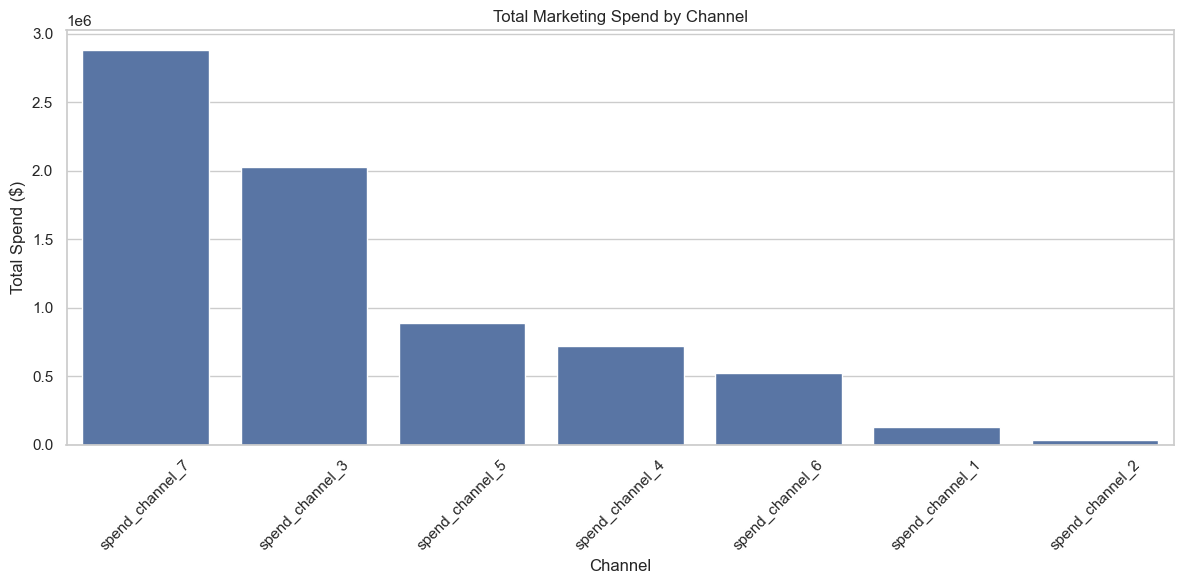

In [201]:
# Extract channel columns
channel_cols = [col for col in df.columns if 'spend_channel' in col]

# Plot total spend by channel
channel_spend = df[channel_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=channel_spend.index, y=channel_spend.values)
plt.title('Total Marketing Spend by Channel')
plt.xlabel('Channel')
plt.ylabel('Total Spend ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Plotting channel spends against revenue

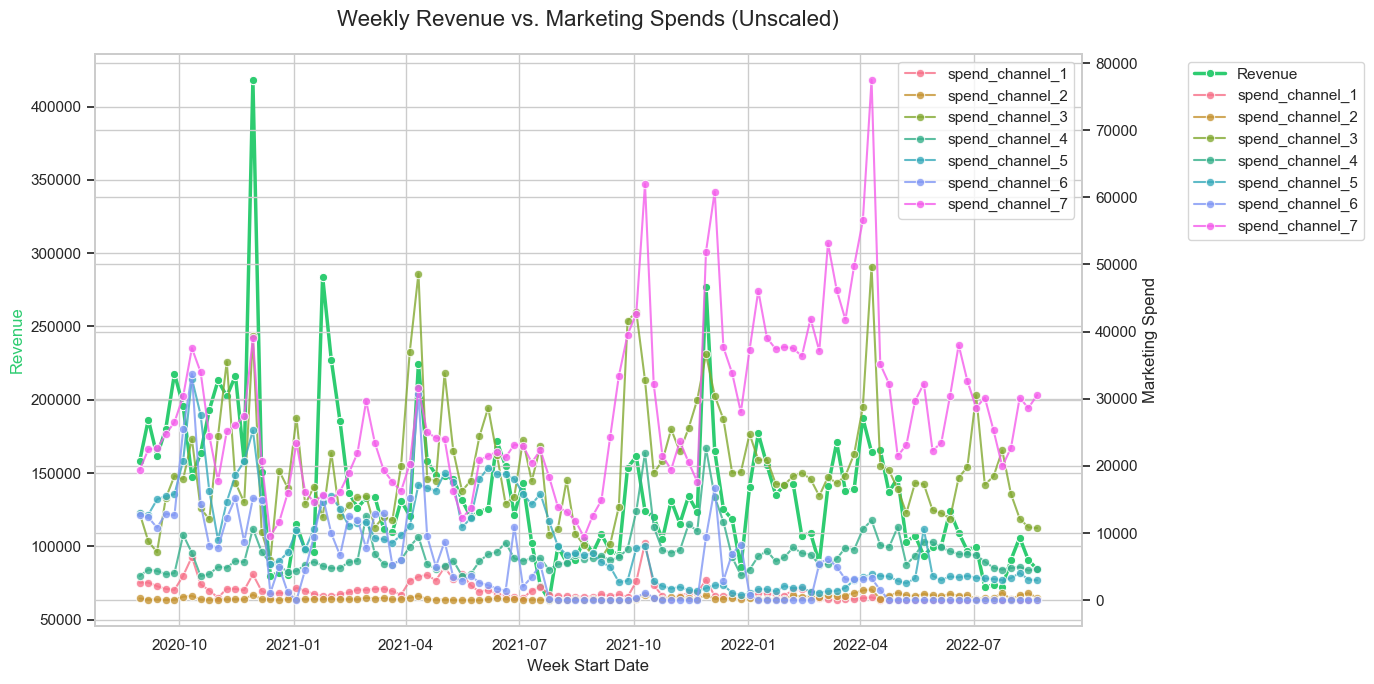

In [220]:
plt.figure(figsize=(14, 7))
ax1 = plt.gca()  # Primary axis for revenue
ax2 = ax1.twinx()  # Secondary axis for spends

# Plot Revenue (Left Axis)
sns.lineplot(data=df, x=df.index, y="revenue", ax=ax1, marker="o", 
             color="#2ecc71", label="Revenue", linewidth=2.5)

# Plot All Spend Channels (Right Axis)
colors = sns.color_palette("husl", n_colors=len(channel_cols))  # Unique colors

for col, color in zip(channel_cols, colors):
    sns.lineplot(data=df, x=df.index, y=col, ax=ax2, marker="o", 
                 color=color, label=col, alpha=0.8)

# Customize Axes
ax1.set_title("Weekly Revenue vs. Marketing Spends (Unscaled)", fontsize=16, pad=20)
ax1.set_xlabel("Week Start Date", fontsize=12)
ax1.set_ylabel("Revenue", fontsize=12, color="#2ecc71")
ax2.set_ylabel("Marketing Spend", fontsize=12)

# Combine Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Exploring Spend and Revenue relation:
##### The below plot gives some insights into media expenditure and revenue patterns. In multiple cases the revenues seem to respond in 6-8 weeks after the media channels' spend was bumped up.

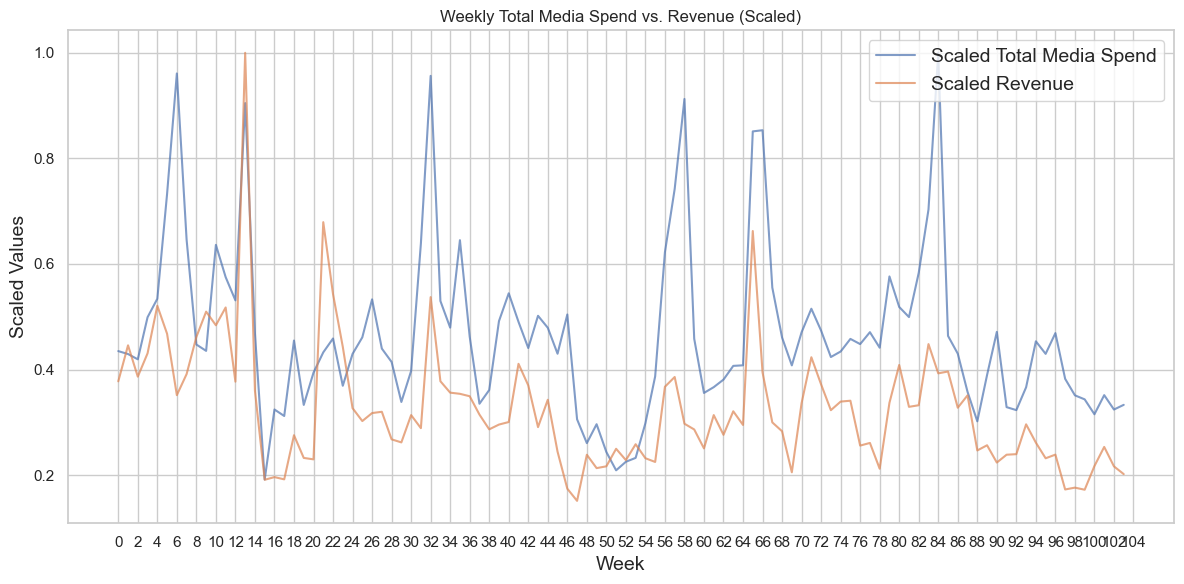

In [221]:
df_with_scaled = df.copy()
df_with_scaled['week_number'] = range(len(df))
df_with_scaled['total_spend'] = df_with_scaled[channel_cols].sum(axis=1)

# Scale revenue
revenue_scaler = MaxAbsScaler()
df_with_scaled["revenue_scaled"] = revenue_scaler.fit_transform(df_with_scaled[['revenue']])
# Scale channel spends
channel_scaler = MaxAbsScaler()
df_with_scaled['total_spend_scaled'] = channel_scaler.fit_transform(df_with_scaled[['total_spend']])

# Create plot
plt.figure(figsize=(12, 6))
plt.plot(df_with_scaled['week_number'], df_with_scaled['total_spend_scaled'], 
         label='Scaled Total Media Spend', alpha=0.7)
plt.plot(df_with_scaled['week_number'], df_with_scaled['revenue_scaled'], 
         label='Scaled Revenue', alpha=0.7)

plt.title('Weekly Total Media Spend vs. Revenue (Scaled)')
plt.xlabel('Week', fontsize=14)
plt.xticks(np.arange(0, 105, 2)) 
plt.ylabel('Scaled Values', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('weekly_scaled_media_vs_revenue.png', dpi=300)
plt.show()

### Visualising the distribution of revenue:
It seems that except a few exceptional weeks, the revenues have consistently remained in the range of around 65K-225K with mean at 136.5K.

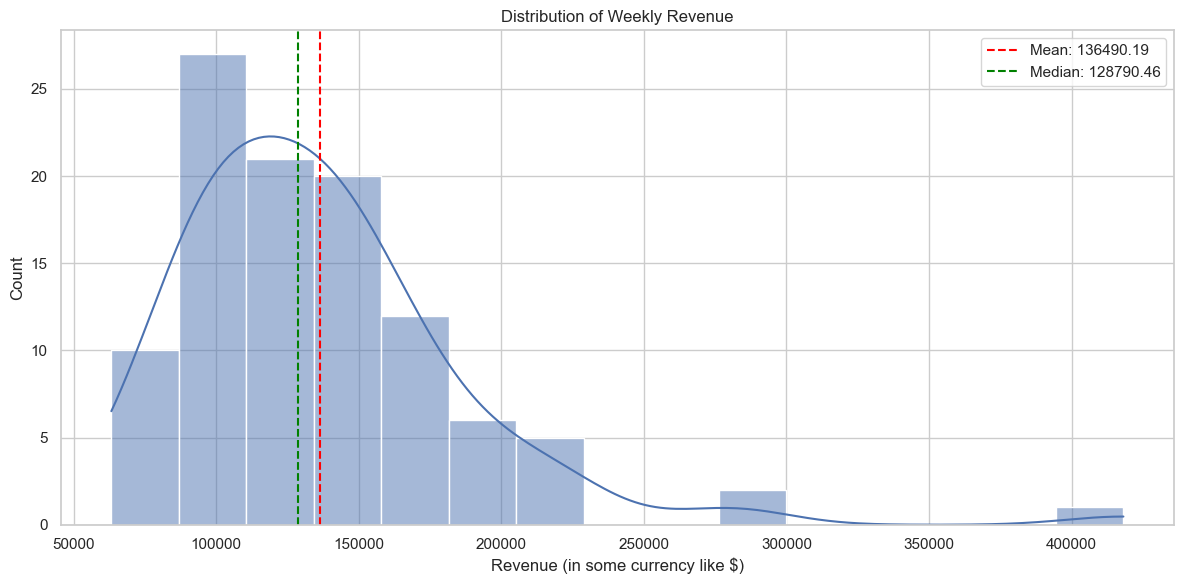

In [222]:
plt.figure(figsize=(12, 6))
sns.histplot(df['revenue'], kde=True)
plt.title('Distribution of Weekly Revenue')
plt.xlabel('Revenue (in some currency like $)')
plt.axvline(df['revenue'].mean(), color='red', linestyle='--', label=f'Mean: {df["revenue"].mean():.2f}')
plt.axvline(df['revenue'].median(), color='green', linestyle='--', label=f'Median: {df["revenue"].median():.2f}')
plt.legend()
plt.tight_layout()

### Visualising the correlations between lagged channel spends and revenue data:
This could help us in hinting at maximum lags for different channels to keep in mind while modeling different channel spends. Note our observation of 7-8 weeks of lag seems to be also backed up by this correlation plot.

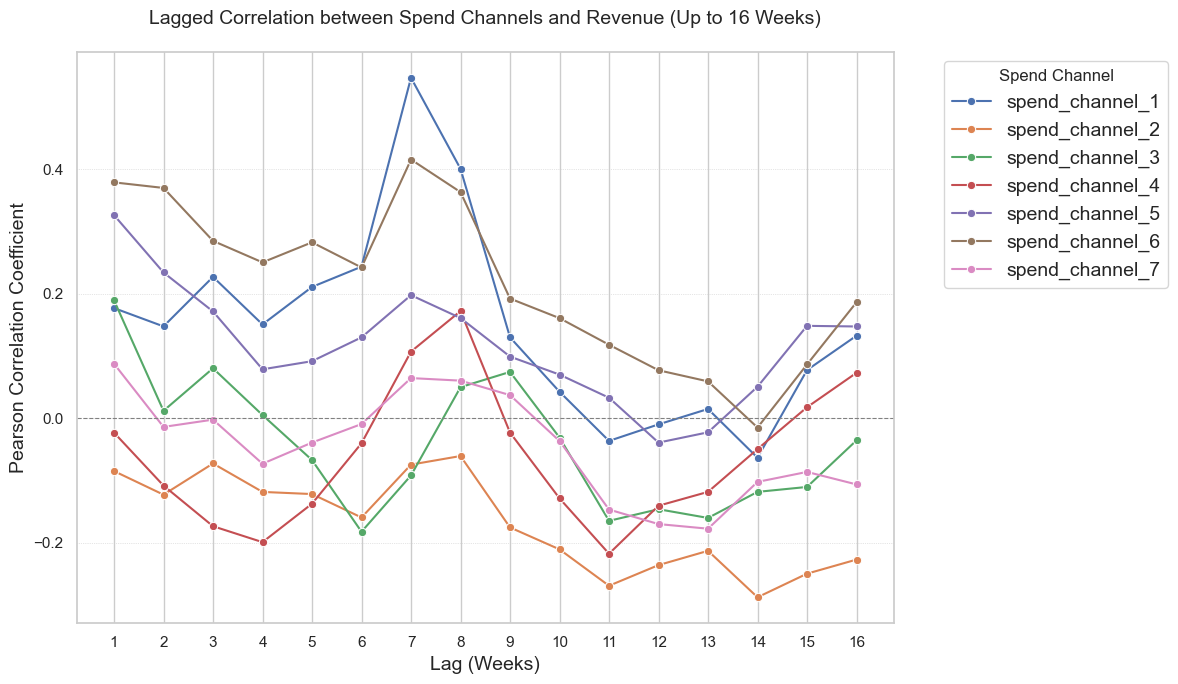

In [223]:
# --- Configuration ---
max_lag = 16 # Define the maximum lag (weeks) to check
# --- End Configuration ---
revenue_col = 'revenue'
# Calculate lagged correlations
lags = range(1, max_lag + 1)
lagged_correlations = pd.DataFrame(index=lags) # Index will be the lag value

for channel in channel_cols:
    channel_corrs = []
    for lag in lags:
        # Calculate correlation between revenue(t) and spend(t - lag)
        # .shift(lag) shifts the spend data *forward* in time, so row `t` contains data from `t-lag`.
        # When correlating with revenue at row `t`, this effectively correlates revenue(t) with spend(t-lag).
        # The .corr() method handles the alignment by index and pairwise NaN removal implicitly.
        correlation = df[revenue_col].corr(df[channel].shift(lag))
        channel_corrs.append(correlation)
    lagged_correlations[channel] = channel_corrs

# --- Plotting ---
plt.figure(figsize=(12, 7))

# Plot correlation for each channel against the lag
for channel in lagged_correlations.columns:
    sns.lineplot(x=lagged_correlations.index, y=lagged_correlations[channel], label=channel, marker='o')

# Add plot enhancements
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Add a line at 0 correlation
plt.title(f'Lagged Correlation between Spend Channels and Revenue (Up to {max_lag} Weeks)', fontsize=14, pad=20)
plt.xlabel('Lag (Weeks)', fontsize=14)
plt.ylabel('Pearson Correlation Coefficient', fontsize=14)
plt.xticks(lags) # Ensure all lag numbers are shown as ticks
plt.legend(title='Spend Channel', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14) # Place legend outside plot
plt.grid(axis='y', linestyle=':', linewidth=0.5)
plt.tight_layout() # Adjust layout to prevent overlapping elements
plt.savefig('lagged_correlation.png', dpi=300)
plt.show()

### Decomposing revenues data into trend and seasonalities (using LOESS method):

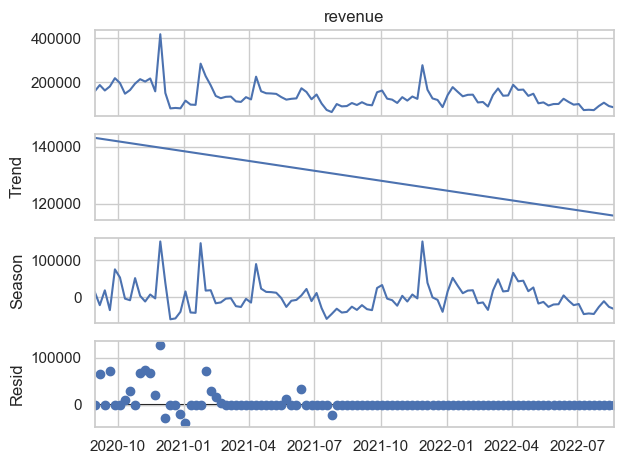

In [243]:
# Decompose revenue with STL (Seasonal-Trend decomposition)
stl = STL(df["revenue"], period=52, robust=True)  # Weekly data with annual seasonality
res = stl.fit()
df_stl = df.copy()

df_stl["trend"] = res.trend
df_stl["seasonal"] = res.seasonal
df_stl["residual"] = res.resid

# Plot components
res.plot()
plt.show()

### Ignoring other control variables like holidays,events a simpler way to express revenues from the spend channels would be:
$Revenue = baseline + trend + seasonality + f_1(sc_1) + f_2(sc_2) + ... + f_6(sc_6) + f_7(sc_7)$

where $sc_n$ is the $n^{th}$ spend channel

These functions $f_n$ will ideally comprise of transformations like adstock and saturation of media spends. Considering only adstock transformations, these functions can comprise an additive expression of present week's spend plus a decayed geometric carry-over of previous weeks channel spend. 

Now instead of having a point estimate of these coefficient thetas, we will like to have a distribution. This is where Bayesian MMM will help us. Not only thetas but MMM will give us distributions for other coefficients (trend and seasonality as well).

With the gathered ideas about data, we can now begin creating our Bayesian MMM using the pymc framework.

In [207]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.3.0


### Begin preparation for MMM model:

In [286]:
df_for_mmm = df.copy()
channel_cols = [col for col in df.columns if 'spend_channel' in col]
# Scale revenue
revenue_scaler = StandardScaler()
df_for_mmm["revenue_scaled"] = revenue_scaler.fit_transform(df_for_mmm[['revenue']])
# Scale channel spends
channel_scaler = StandardScaler()
df_for_mmm[channel_cols] = channel_scaler.fit_transform(df_for_mmm[channel_cols])
# Time index
df_for_mmm["t"] = np.arange(len(df_for_mmm))
def add_fourier_terms(df, period, order, prefix):
    for i in range(1, order + 1):
        df[f'{prefix}_sin_{i}'] = np.sin(2 * np.pi * i * df["t"] / period)
        df[f'{prefix}_cos_{i}'] = np.cos(2 * np.pi * i * df["t"] / period)
    return df

# Weekly data -> annual seasonality with period=52 (weeks in a year)
df_for_mmm = add_fourier_terms(df_for_mmm, period=52, order=3, prefix="annual")

df_for_mmm = add_fourier_terms(df_for_mmm, period=13, order=2, prefix="quarterly")

# Final matrices
X = df_for_mmm[channel_cols].values
y = df_for_mmm["revenue_scaled"].values
# Use the normalized 't' specifically for the trend component later
df_for_mmm["t_normalized"] = np.arange(len(df_for_mmm)) / len(df_for_mmm)
t_norm = df_for_mmm["t_normalized"].values # Use this for trend in the model
# Combine all Fourier terms for seasonality modeling
fourier_terms = df_for_mmm[[col for col in df_for_mmm.columns if "sin" in col or "cos" in col]].values
fourier_cols = [col for col in df_for_mmm.columns if "sin" in col or "cos" in col]
df_for_mmm.head()

,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7,revenue_scaled,t,...,annual_cos_1,annual_sin_2,annual_cos_2,annual_sin_3,annual_cos_3,quarterly_sin_1,quarterly_cos_1,quarterly_sin_2,quarterly_cos_2,t_normalized
start_of_week,,,,,,,,,,,,,,,,,,,,,
2020-08-30,157906.75,0.998684,-0.244221,-0.755591,-1.063507,0.632603,1.140927,-0.686734,0.423542,0,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
2020-09-06,186425.68,1.004858,-0.709091,-1.239155,-0.757544,0.602619,1.092718,-0.431431,0.987543,1,...,0.992709,0.239316,0.970942,0.354605,0.935016,0.464723,0.885456,0.822984,0.568065,0.009615
2020-09-13,161607.39,0.609017,-0.704082,-1.424201,-0.821132,0.930168,0.863339,-0.421314,0.496727,2,...,0.970942,0.464723,0.885456,0.663123,0.748511,0.822984,0.568065,0.935016,-0.354605,0.019231
2020-09-20,180089.13,0.322137,-0.877687,-0.498337,-0.975421,1.003255,1.175642,-0.245315,0.862229,3,...,0.935016,0.663123,0.748511,0.885456,0.464723,0.992709,0.120537,0.239316,-0.970942,0.028846
2020-09-27,217793.98,0.218352,-0.793887,-0.113358,-0.924046,1.042591,1.138438,-0.097865,1.607894,4,...,0.885456,0.822984,0.568065,0.992709,0.120537,0.935016,-0.354605,-0.663123,-0.748511,0.038462


##### Below adstock function is my python implementation but since pymc works with pytensor, the final version is the one following it. I have still kep the below for my own understanding.

In [172]:
def apply_adstock_tensor_simpler_for_understanding(X, alpha_vec, l_max=12):
    """
    Apply geometric adstock transformation to media channels using pytensor operations.
    
    Parameters:
    X : pytensor.tensor
        Media data with shape (time, channels)
    alpha_vec : pytensor.tensor
        Vector of decay parameters with shape (channels,)
    l_max : int
        Maximum lag to consider
        
    Returns:
    pytensor.tensor
        Adstocked media data with shape (time, channels)
    """
    time_periods, n_channels = X.shape
    result = pt.zeros_like(X)
    
    # Loop through each channel
    for i in range(n_channels):
        channel_data = X[:, i]
        alpha = alpha_vec[i]
        
        # Create the decay weights vector for this channel
        decay_weights = pt.power(alpha, pt.arange(l_max))
        
        # For each time period, calculate the adstocked value
        for t in range(time_periods):
            # Calculate how far back we can go (limited by available history)
            max_lag = pt.minimum(t+1, l_max)
            
            # Get the relevant slice of data for this time period
            history_indices = pt.arange(t, t-max_lag, -1)
            history = channel_data[history_indices]
            
            # Apply weights to the history and sum
            weighted_history = history * decay_weights[:max_lag]
            adstock_value = pt.sum(weighted_history)
            
            # Update the result tensor
            result = pt.set_subtensor(result[t, i], adstock_value)
    
    return result

### Pytensor implementation of geometric delayed adstock function:

In [287]:
def apply_adstock_tensor(X, alpha_vec, l_max=8):
    """Symbolic adstock application to all channels using pytensor.scan."""

    def adstock_one_channel(x_i, alpha_i):
        """Adstock a single channel over time."""
        cycles = [pt.concatenate([pt.zeros(i), x_i[:x_i.shape[0] - i]]) for i in range(l_max)]
        x_cycle = pt.stack(cycles)  # (lags, time)
        weights = pt.stack([alpha_i ** i for i in range(l_max)])
        return pt.dot(weights, x_cycle)  # (time,)

    # Scan over channels
    def scan_fn(i, X, alpha_vec):
        return adstock_one_channel(X[:, i], alpha_vec[i])

    idxs = pt.arange(X.shape[1])
    adstocked_channels, _ = pytensor.scan(fn=scan_fn,
                                          sequences=[idxs],
                                          non_sequences=[X, alpha_vec])

    return adstocked_channels.dimshuffle(1, 0)  # shape: (time, channels)

### Setting up the MMM model with priors:

J:\Uni_Frieburg\HiringChallenges\HaenselAMS\venv\lib\site-packages\pymc\data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Sampling: [alpha, baseline, beta_channel, beta_season, beta_trend, sigma, y_obs]


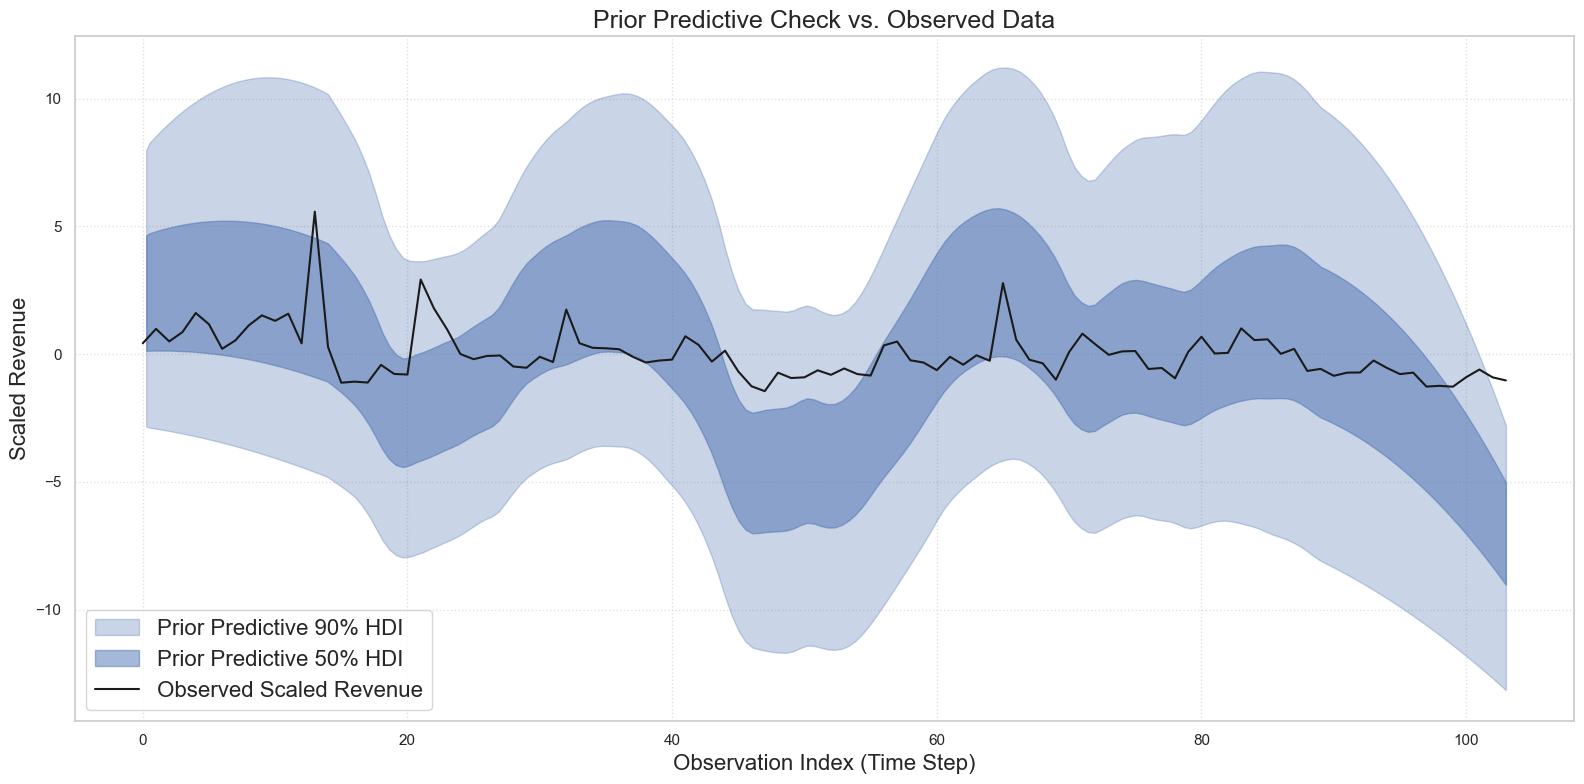

In [288]:
# Set up coordinate system for the model dimensions
coords = {
    "obs": df_for_mmm.index,
    "channel": channel_cols,
    "fourier": fourier_cols
}

with pm.Model(coords=coords) as mmm:

    # Data containers
    X_data = pm.Data("X_data", X, dims=("obs", "channel"))
    fourier_data = pm.Data("fourier_data", fourier_terms, dims=("obs", "fourier"))
    t_data = pm.Data("t_data", t_norm, dims="obs")

    # PRIORS
    baseline = pm.Normal("baseline", mu=0, sigma=1.0)

    beta_trend = pm.Normal("beta_trend", mu=0, sigma=1.0)
    beta_season = pm.Normal("beta_season", mu=0, sigma=0.5, dims="fourier")

    alpha = pm.Beta("alpha", alpha=2.0, beta=2.0, dims="channel")  # adstock decay
    # Channel effectiveness parameters - how much each $1 in channel contributes to revenue
    beta_channel = pm.HalfNormal("beta_channel", sigma=1, dims="channel")
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    adstocked_X = apply_adstock_tensor(X_data, alpha, l_max=14)
    # marketing_effect = pt.sum(adstocked_X * beta_channel, axis=1)
    marketing_effect = adstocked_X * beta_channel
    channel_contribution = pm.Deterministic("channel_contribution", marketing_effect, dims=("obs", "channel"))
    marketing_effect_vec = pt.sum(marketing_effect, axis=1)
    seasonality = pt.sum(fourier_data * beta_season, axis=1)
    trend = beta_trend * t_data

    # Combined model: baseline + trend + seasonality + marketing effects
    mu = baseline + trend + seasonality + marketing_effect_vec
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y, dims="obs")
    prior_pred = pm.sample_prior_predictive(random_seed=42)
    
# Extract the prior predictive samples for 'y_obs'
# This is an xarray DataArray with dims like (chain, draw, obs_dim)
prior_y_samples_xr = prior_pred.prior_predictive["y_obs"]

# Get the number of observations to create a time index
num_observations = len(y)
time_index = np.arange(num_observations)

# --- Plotting ---
plt.figure(figsize=(16, 8))

# Plot multiple prior predictive samples as faint lines
# Stack chains and draws to make iteration easier
# Use .transpose(..., "sample") if needed depending on plot_hdi internals
az.plot_hdi(
    time_index,
    prior_y_samples_xr,
    hdi_prob=0.9, # Plot 90% Highest Density Interval
    color='C0',
    fill_kwargs={'alpha': 0.3, 'label': 'Prior Predictive 90% HDI'}
)
az.plot_hdi(
    time_index,
    prior_y_samples_xr,
    hdi_prob=0.5, # Plot 50% Highest Density Interval
    color='C0',
    fill_kwargs={'alpha': 0.5, 'label': 'Prior Predictive 50% HDI'}
)
# Plot the actual observed data
plt.plot(time_index, y, color='k', linestyle='-', linewidth=1.5, label='Observed Scaled Revenue')

# Add labels, title, legend
plt.title('Prior Predictive Check vs. Observed Data', fontsize=18)
plt.xlabel('Observation Index (Time Step)', fontsize=16)
plt.ylabel('Scaled Revenue', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()

# Save or show
plt.savefig('prior_predictive_check.png', dpi=300)
plt.show()

### Sampling to build our posterior distribution:

In [289]:
with mmm:
    trace = pm.sample(draws=1000, tune=1000, random_seed=42, target_accept=0.80, return_inferencedata=True)

    posterior_pred = pm.sample_posterior_predictive(trace, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline, beta_trend, beta_season, alpha, beta_channel, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 114 seconds.
Sampling: [y_obs]


### Plotting the posterior distribution against the scaled revenue

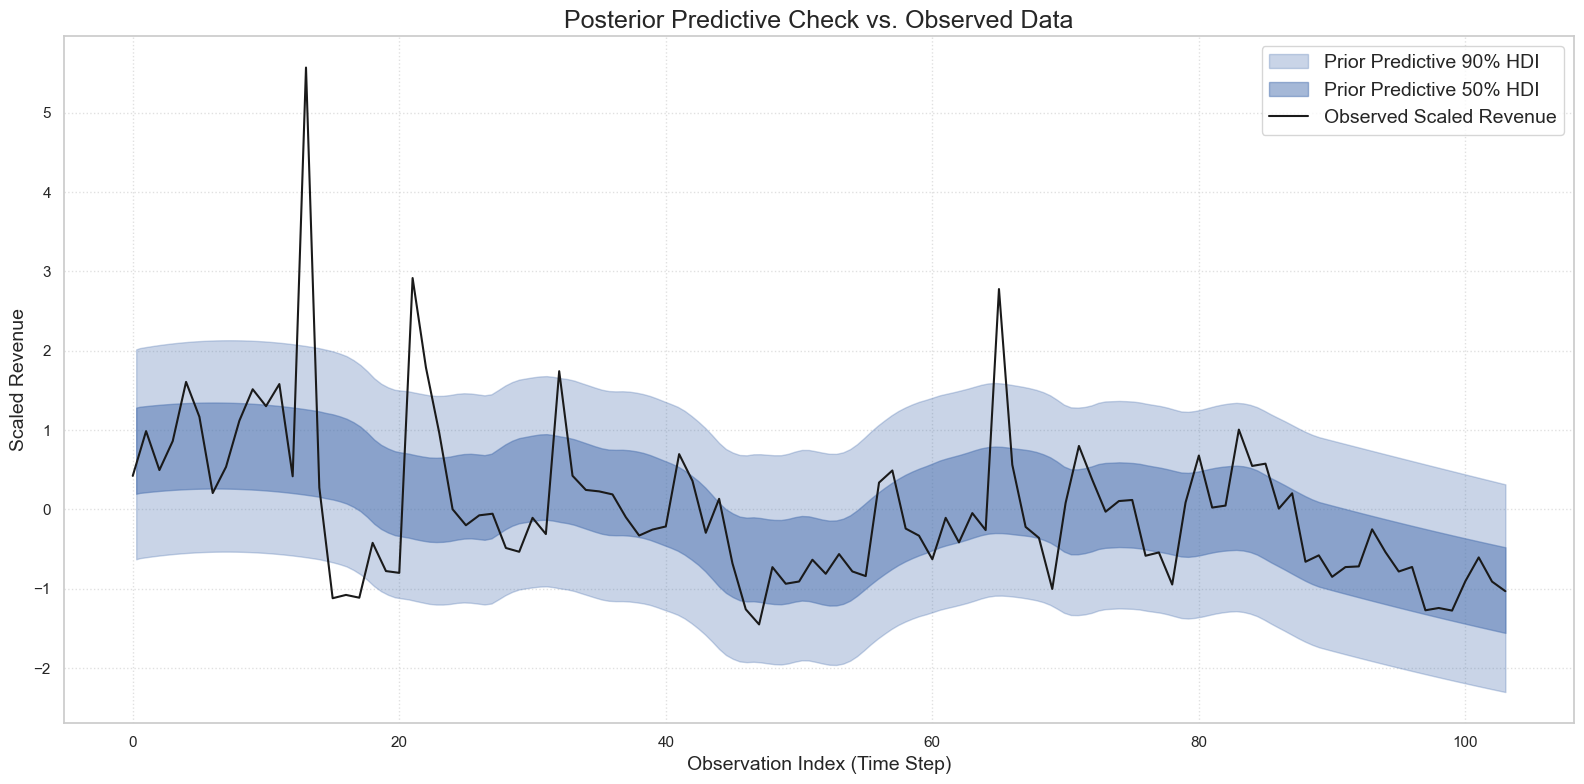

In [290]:
# Extract the prior predictive samples for 'y_obs'
# This is an xarray DataArray with dims like (chain, draw, obs_dim)
posterior_y_samples_xr = posterior_pred.posterior_predictive["y_obs"]

# Get the number of observations to create a time index
num_observations = len(y)
time_index = np.arange(num_observations)

# --- Plotting ---
plt.figure(figsize=(16, 8))

# Plot multiple prior predictive samples as faint lines
# Stack chains and draws to make iteration easier
# Use .transpose(..., "sample") if needed depending on plot_hdi internals
az.plot_hdi(
    time_index,
    posterior_y_samples_xr,
    hdi_prob=0.9, # Plot 90% Highest Density Interval
    color='C0',
    fill_kwargs={'alpha': 0.3, 'label': 'Prior Predictive 90% HDI'}
)
az.plot_hdi(
    time_index,
    posterior_y_samples_xr,
    hdi_prob=0.5, # Plot 50% Highest Density Interval
    color='C0',
    fill_kwargs={'alpha': 0.5, 'label': 'Prior Predictive 50% HDI'}
)
# Plot the actual observed data
plt.plot(time_index, y, color='k', linestyle='-', linewidth=1.5, label='Observed Scaled Revenue')

# Add labels, title, legend
plt.title('Posterior Predictive Check vs. Observed Data', fontsize=18)
plt.xlabel('Observation Index (Time Step)', fontsize=14)
plt.ylabel('Scaled Revenue', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()

# Save or show
plt.savefig('posterior_predictive_check.png', dpi=300)
plt.show()

### Calculating some regression metrics on mean of sampled distribution of revenue to evaluate how close our prediction is to the target:

In [291]:
# Inverse transform predictions
y_pred_scaled = posterior_pred.posterior_predictive["y_obs"].mean(dim=["chain", "draw"]).values
y_pred = revenue_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = df["revenue"].values

# Compute R² or MAE
from sklearn.metrics import r2_score, mean_absolute_error
print("R²:", r2_score(y_true, y_pred))
print("MAE:", mean_absolute_error(y_true, y_pred))

R²: 0.5343869278481868
MAE: 24041.83998172229


### Checking effectiveness of each channel (beta channels) from the posterior:
Channel 3 seems to have the highest mean effectiveness followed by channel 5.

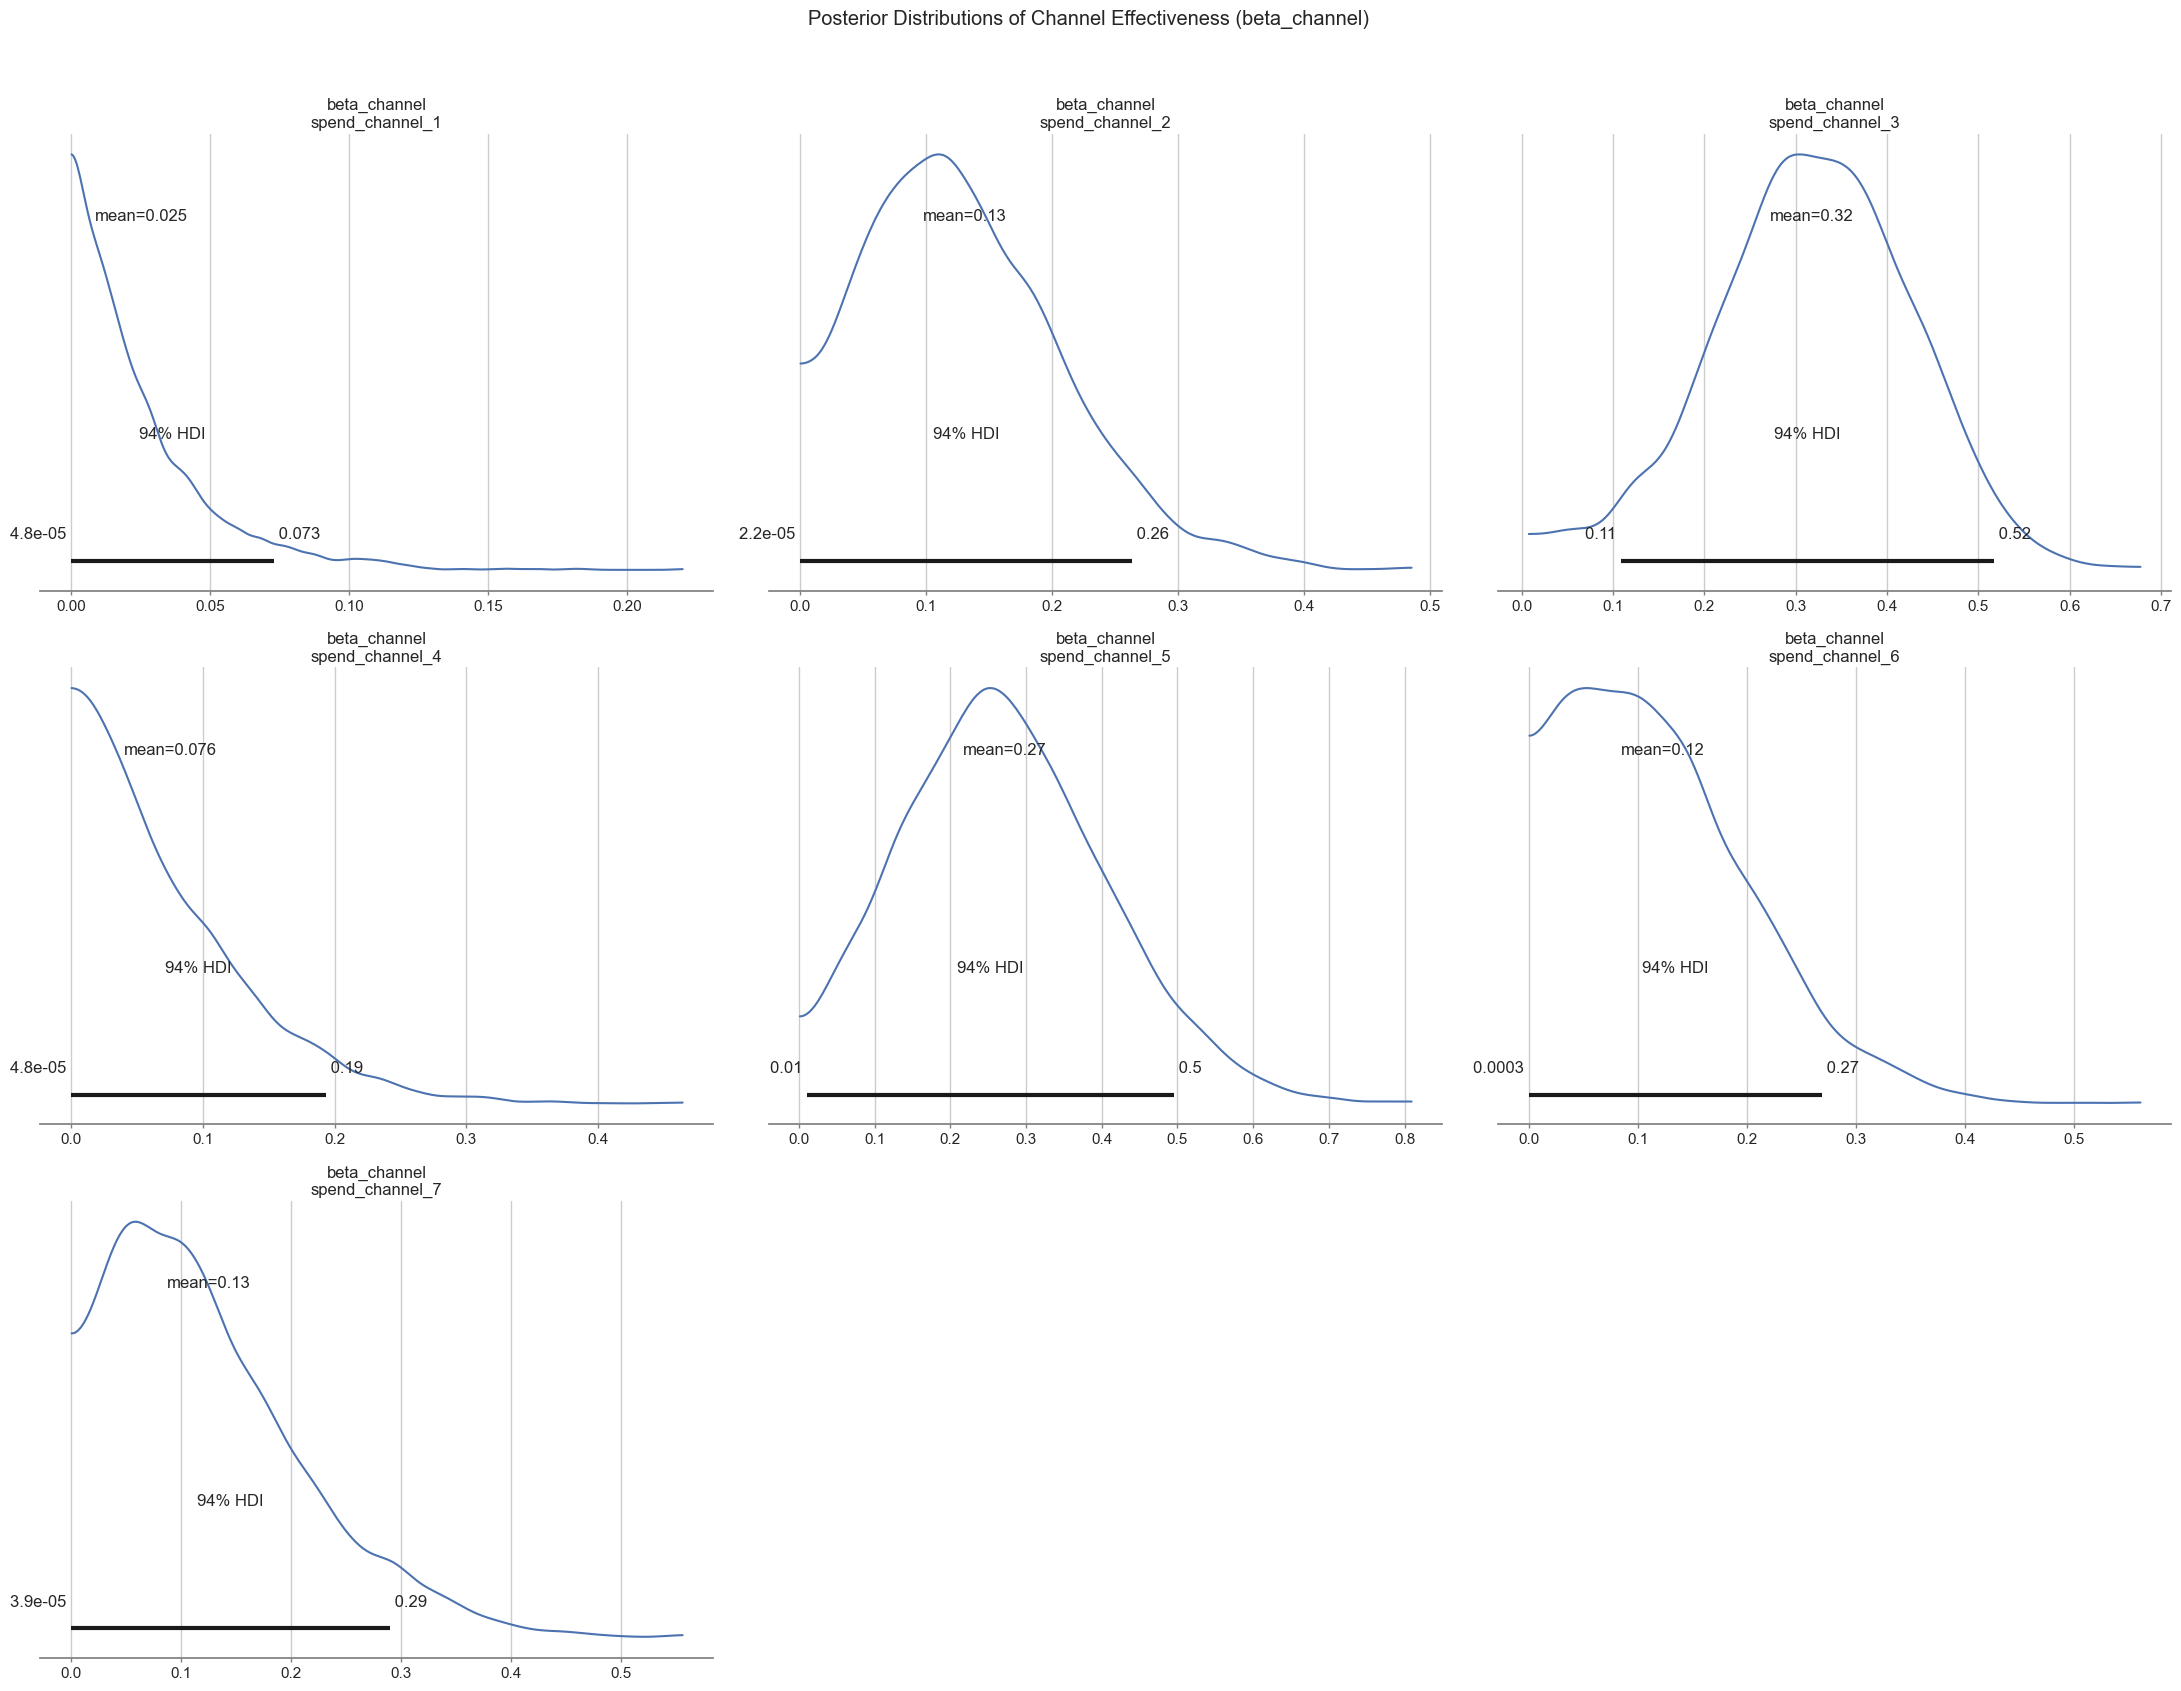

In [277]:
az.plot_posterior(trace, var_names=["beta_channel"])
plt.suptitle("Posterior Distributions of Channel Effectiveness (beta_channel)", y=1.02)
plt.tight_layout()
plt.show()

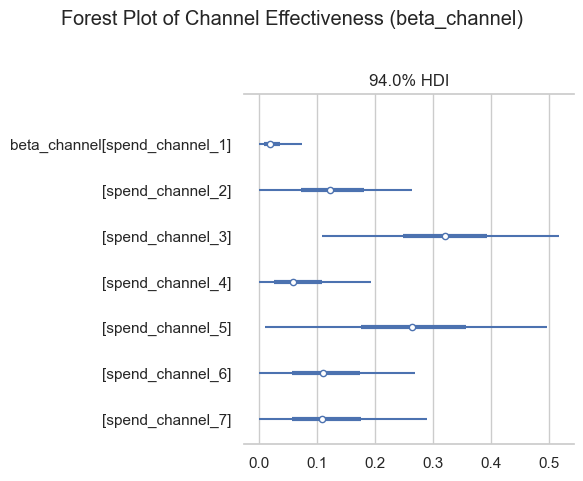

In [278]:
# A forest plot is often better for comparing parameters
az.plot_forest(trace, var_names=["beta_channel"], combined=True, hdi_prob=0.94)
plt.suptitle("Forest Plot of Channel Effectiveness (beta_channel)", y=1.02)
plt.tight_layout()
plt.show()

### Naive calculation of ROI (without taking adstock effects into account):

In [285]:
# Get std dev of original revenue and spend (for scaling back to ROI in original units)
revenue_std = revenue_scaler.scale_[0]
channel_stds = channel_scaler.scale_

# Posterior mean of beta_channel across chains and draws
beta_means = beta_channel_samples.mean(dim=("chain", "draw")).values  # shape: (channels,)

# ROI in original units: additional revenue ($) per $1 spent
roi_per_channel = (beta_means * revenue_std) / channel_stds

# Display nicely
roi_df = pd.DataFrame({
    "channel": channel_cols,
    "ROI ($ revenue per $1 spend)": roi_per_channel
})
print(roi_df)

           channel  ROI ($ revenue per $1 spend)
0  spend_channel_1                      0.930984
1  spend_channel_2                     20.025231
2  spend_channel_3                      1.850265
3  spend_channel_4                      1.228298
4  spend_channel_5                      1.982480
5  spend_channel_6                      0.937509
6  spend_channel_7                      0.523525
